In [1]:
#------ manually fix import for now
import sys
sys.path.append('..')
#------

import numpy as np
import astropy.units as u
from redexo import *
import matplotlib.pyplot as plt
import copy

### Loading the data

Loading 94 files...


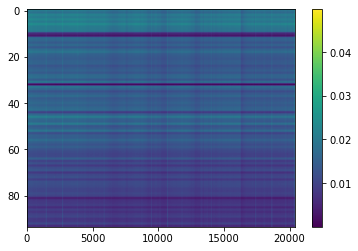

In [9]:
dataset = load_carmenes_data(folder='/users/ricolandman/Documents/Research/OH_exoplanets/Data/Wasp33_night1/',\
                            spectral_orders=[23,24,25,26,27])

plt.imshow(dataset.spec.reshape(dataset.num_exposures,-1),aspect='auto')
plt.colorbar()
plt.show()

### Define target

In [10]:
#planet = Planet(Kp=231, vsys=-4.63, T0=2458804.829075, orbital_period=1.2198709)
planet = Planet(Kp=231, vsys=-9.2, T0=2454163.223670, orbital_period=1.219870890)

planet.transit_start = 0.046

### Load template spectrum

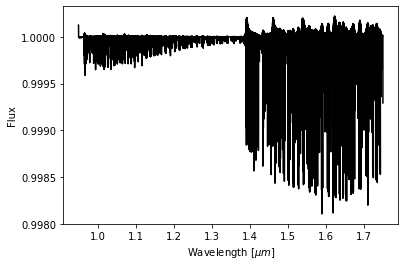

In [11]:
template_wl, template = np.load('/users/ricolandman/Documents/Research/OH_exoplanets/Data/models/Wasp76_OH_equilibrium_T=3200K_prepared.npy')
plt.plot(template_wl/1e4, template, color='black')
plt.xlabel(r'Wavelength [$\mu m$]')
plt.ylabel('Flux')
plt.show()

### Define pipeline

In [12]:
pipeline = Pipeline()

#pipeline.add_module( InjectSignalModule(template=template, template_wl=template_wl, target=planet, savename='injection') )

pipeline.add_module( FlagAbsorptionEmissionModule(flux_lower_limit=0.4, flux_upper_limit=1.1, 
                                                    relative_to_continuum=True) )
pipeline.add_module( PolynomialContinuumRemovalModule(poly_order=3))


pipeline.add_module( OutlierFlaggingModule(sigma=5) )

pipeline.add_module( SysRemModule(number_of_modes=4, mode='subtract', name='cleaned') )
#pipeline.add_module( PCASubtractModule(number_of_modes=12))

pipeline.add_module( CrossCorrelationModule(template = template, template_wl = template_wl, 
                                            rv_range=300, drv=1.3, error_weighted=True))
pipeline.add_module( CoAddOrders(name='co_added', weights=None))
pipeline.add_module( ShiftRestFrameModule(target=planet, name='CCF_map_planet'))
pipeline.add_module( CoAddExposures(name='1D_CCF', weights=planet.in_transit(dataset.obstimes)))

In [13]:
pipeline.run(dataset, num_workers=None, per_order=True) 
pipeline.summary()

ValueError: operands could not be broadcast together with shapes (169,) (462,1,94) 

### Look at results

In [ ]:
ccf_map_earth = pipeline.get_results('co_added')
ccf_map_planet = pipeline.get_results('CCF_map_planet')
ccf = pipeline.get_results('1D_CCF')

phases = planet.orbital_phase(dataset.obstimes)
vmax = np.percentile(ccf_map_earth.spec, 99.6)
plt.figure()
plt.imshow(ccf_map_earth.spec[:,0,:], aspect='auto', cmap='inferno', origin='lower', 
           extent=[ccf_map_earth.rv_grid.min(), ccf_map_earth.rv_grid.max(),min(phases),max(phases)],
            vmin =-vmax, vmax=vmax, interpolation='none')
plt.xlim(-250,250)
plt.colorbar()
plt.xlabel('RV [km/s]')
plt.show()

In [ ]:
Kp_list = np.arange(-50,350, 1.3)
snr_map = make_kp_vsys_map(ccf_map_earth, Kp_list, planet)
print('SNR:', np.max(snr_map))

fig, axes = plt.subplots(nrows=3, ncols=2, sharex='col',
                           gridspec_kw={'height_ratios': [1,1, 3],
                            'width_ratios':[20,1]},
                           figsize=(6, 7.5))

rv_grid = ccf_map_earth.rv_grid
plt.sca(axes[2,0])
im= plt.imshow( snr_map, extent=[np.min(rv_grid),np.max(rv_grid), np.min(Kp_list), np.max(Kp_list)],origin='lower',
    cmap='gist_heat', interpolation='none', aspect='auto')

plt.axhline(planet.Kp,ls='--', color='white')
plt.axvline(planet.vsys,ls='--', color='white')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-80,80)
plt.ylim(-50,350)
plt.xlabel(r'$v_{\mathrm{rest}}$ [km/s]', fontsize=14)
plt.ylabel(r'$K_p$ [km/s]', fontsize=14)
cbar = fig.colorbar(im,cax=axes[2,1])
cbar.set_label(label='Signal-to-noise ratio', size='large')
cbar.ax.tick_params(labelsize=12) 
plt.xlim(-250,250)

max_kp_index= np.where(snr_map==snr_map.max())[0][0]
#max_kp_index = np.argmin(np.abs(Kp_list.value-234))
max_kp_index = 10
max_kp = Kp_list[max_kp_index]
true_kp_index = np.argmin(np.abs(Kp_list-planet.Kp))
ccf = snr_map[max_kp_index]
ccf2 = snr_map[true_kp_index]


plt.sca(axes[0,0])
plt.plot(rv_grid[0,0], ccf2, color='black')
plt.title('Kp={0:.1f} km/s'.format(planet.Kp), fontsize=12)
plt.yticks([-2,0,2,4,6],fontsize=12)
plt.grid()
plt.axhline(0, color='black', ls='--',alpha=0.6)
plt.ylabel('SNR',fontsize=12)


plt.sca(axes[1,0])
plt.plot(rv_grid[0,0], ccf, color='black')
plt.title('Kp={0:.1f} km/s'.format(max_kp), fontsize=12)
plt.axhline(0, color='black', ls='--',alpha=0.6)
mask = (rv_grid<10)*(rv_grid>-30)
plt.grid()
plt.ylabel('SNR',fontsize=12)
plt.yticks([-2,0,2,4,6],fontsize=12)
#plt.xticks([])
plt.sca(axes[0,1])
plt.axis('off')
plt.sca(axes[1,1])
plt.axis('off')
plt.tight_layout()